# Tarea 3 : Mongo DB arXiv
| ROL         | Nombre          |
|-------------|-----------------|
| 202373037-8 | Matias Peñaloza |
| 202373020-3 | Hans González   |

In [1]:
from pymongo import MongoClient
from pymongo.cursor import Cursor

In [2]:
client = MongoClient("mongodb://mongo1:30001,mongo2:30002,mongo3:30003/?replicaSet=my-replica-set&readPreference=primary&appname=MongoDB%20Compass&ssl=false")
db = client["arxiv_db"]
collection = db["articles"]

In [3]:
import json
from IPython.display import display, HTML

def __print_article(article, fields):
    if "_id" in fields:
        article["_id"] = str(article["_id"])
    filtered = {field: article[field] for field in fields if field in article}
    json_str = json.dumps(filtered, indent=2, ensure_ascii=False)
    json_str = json_str.replace("<", "&lt;").replace(">", "&gt;")
    html = f"<pre>{json_str}</pre><hr>"
    display(HTML(html))

def print_articles(articles:Cursor, debug=False):
    articles = list(articles)
    print(f"Total de artículos encontrados: {len(articles)}")
    if not articles:
        display(HTML("<b>No se encontraron artículos.</b>"))
        return
    fields = [field for field in articles[0].keys() if field != "_id" or debug]
    for article in articles:
        __print_article(article, fields)

# Consultas
### Tipo de documento
```js
{
  "_id": ObjectId,
  "id": string,
  "submitter": string,
  "authors": string,
  "title": string,
  "comments": string,
  "journal-ref": string,
  "doi": string,
  "report-no": string,
  "categories": string,
  "license": string,
  "abstract": string,
  "versions": array,
  "update_date": string, // (YYYY-MM-DD)
  "authors_parsed": array,
  "pdf_source": string
}
```
#### a. Devolver los títulos y fechas de creación de artículos publicados en el año 2025. Mostrar solo esos campos y limitar a los primeros 20 resultados.

In [4]:
res = collection.find({
    "versions.0.created": {
        "$regex": ".2025.",
        "$options": "s",
    },
}, {
    "title": 1,
    "created": {
        "$arrayElemAt": ["$versions.created", 0]
    },
},
    limit=20
)
print_articles(res)

Total de artículos encontrados: 20


#### b. Devolver los títulos y los autores de artículos que pertenezcan a las categorías "cs.AI" o "stat.ML" y que tengan al menos tres autores. Mostrar solo esos campos y limitar a los primeros 10 resultados.

In [5]:
res = collection.find({
    "$expr": {
        "$gte": [3 , {"$size": "$authors_parsed"}]
    },
    "categories": {
        "$in": ["cs.AI", "stat.ML"]
    }
}, {
    "title": 1,
    "authors_parsed": 1,
},
    limit=10
)
print_articles(res)

Total de artículos encontrados: 10


#### c. Devolver los títulos, las categorías y los enlaces al PDF de artículos que pertenezcan a la categoría "hep-ph" y tengan un DOI asignado. Mostrar solo esos campos y limitar a 15 resultados.


In [6]:
res = collection.find({
    "categories": "hep-ph",
    "doi": { "$ne": None }
}, {
    "title": 1,
    "categories": 1,
    "pdf_source": 1,
},
    limit=15
)
print_articles(res)

Total de artículos encontrados: 15


#### d. Devolver los títulos, nombres de los autores y la referencia de publicación (journal-ref) de los artículos que tengan un DOI asignado. Mostrar solo esos campos y ordenar los resultados alfabéticamente por título. Limitar a los primeros 20 resultados.


In [7]:
res = collection.find({
    "doi": {"$ne": None },
}, {
    "title": 1,
    "authors_parsed": 1,
    "journal-ref": 1,
},
    limit=20,
    sort=[
        ("title", 1)
    ]
)
print_articles(res)

Total de artículos encontrados: 20


#### e. Devolver los títulos y la fecha de la primera versión (versions.created) de los artículos enviados entre los años 2010 y 2015. Mostrar solo esos campos y limitar a los primeros 15 resultados.


In [8]:
res = collection.find({
    "update_date": {
        "$gte": "2010-01-01",
        "$lt": "2015-01-01"
    },
}, {
    "title": 1,
    "created": {
        "$arrayElemAt": ["$versions.created", 0]
    }
},
    limit=15
)
print_articles(res)

Total de artículos encontrados: 15


#### f. Devolver los títulos, comentarios y reportes técnicos (report-no) de artículos que tengan comentarios definidos y no nulos. Mostrar solo esos campos, ordenando por fecha de actualización (update_date) en orden descendente. Limitar a 10 resultados.

In [9]:
res = collection.find({
    "comments": {
        "$exists": True,
        "$ne": None
    },
}, {
    "title": 1,
    "comments": 1,
    "report-no": 1,
},
    limit=10,
    sort=[
        ("update_date", -1)
    ]
)
print_articles(res)

Total de artículos encontrados: 10


# Consistencia
para demostrar consistencia de los datos, insertaremos, actualizaremos y eliminaremos 1 articulo de prueba, Consultandolo en los 3 nodos.

In [10]:
def check_article(article_id:str, nodes: dict[str,str]) -> bool:
    found = True
    for node_name, url in nodes.items():
        try:
            client = MongoClient(url)
            db = client["arxiv_db"]
            collection = db["articles"]
            article = collection.find_one({"_id": article_id})
            if article:
                print(f"Articulo encontrado en {node_name}:")
                __print_article(article, ["title", "authors_parsed", "categories"])
            else:
                print(f"Articulo no encontrado en {node_name}.")
            found = found and (article is not None)
        except Exception as e:
            print(f"Error al conectar con {node_name}: {e}")
    return found

In [11]:
articulo_test = {
    "_id": "__test123__",
    "title": "===== Test Article =====",
    "authors_parsed": ["Author One", "Author Two"],
    "categories": ["cs.AI", "stat.ML"],
}

nodes = {
    "mongo1": "mongodb://mongo1:30001/",
    "mongo2": "mongodb://mongo2:30002/",
    "mongo3": "mongodb://mongo3:30003/",
}

In [16]:
# ================= INSERCION DE ARTICULO DE PRUEBA =================
print("=== Insercion de articulo de prueba ===")
collection.insert_one(articulo_test)
check_article(articulo_test["_id"], nodes)

# =============== ACTUALIZACION DE ARTICULO DE PRUEBA ===============
print("=== Actualizacion de articulo de prueba ===")
collection.update_one(
    {"_id": articulo_test["_id"]},
    {"$set": {"title": "===== Updated Test Article ====="}}
)
check_article(articulo_test["_id"], nodes)

# ================= BORRADO DE ARTICULO DE PRUEBA =================
print("=== Borrado de articulo de prueba ===")
collection.delete_one({"_id": articulo_test["_id"]})
check_article(articulo_test["_id"], nodes)

=== Insercion de articulo de prueba ===
Articulo encontrado en mongo1:


Articulo encontrado en mongo2:


Articulo encontrado en mongo3:


=== Actualizacion de articulo de prueba ===
Articulo encontrado en mongo1:


Articulo encontrado en mongo2:


Articulo encontrado en mongo3:


=== Borrado de articulo de prueba ===
Articulo no encontrado en mongo1.
Articulo no encontrado en mongo2.
Articulo no encontrado en mongo3.


False

# Disponibilidad
Para demostrar disponibilidad bajaremos el nodo principal y consultaremos por los primeros 5 elementos de la base de datos

In [17]:
def print_status(client:MongoClient):
    try:
        status = client.admin.command("replSetGetStatus")
        print("Estado del Replica Set:")
        for member in status["members"]:
            print(f"  - {member['name']}: {member['stateStr']}")
    except Exception as e:
        print(f"Error al obtener el estado del Replica Set: {e}")

In [18]:
print_status(client)

Estado del Replica Set:
  - mongo1:30001: PRIMARY
  - mongo2:30002: SECONDARY
  - mongo3:30003: SECONDARY


ya que no es posible bajar contenedor de docker en linux a traves de comandos de notebooks, se adjunta una prueba de que se bajo el servicio primary.

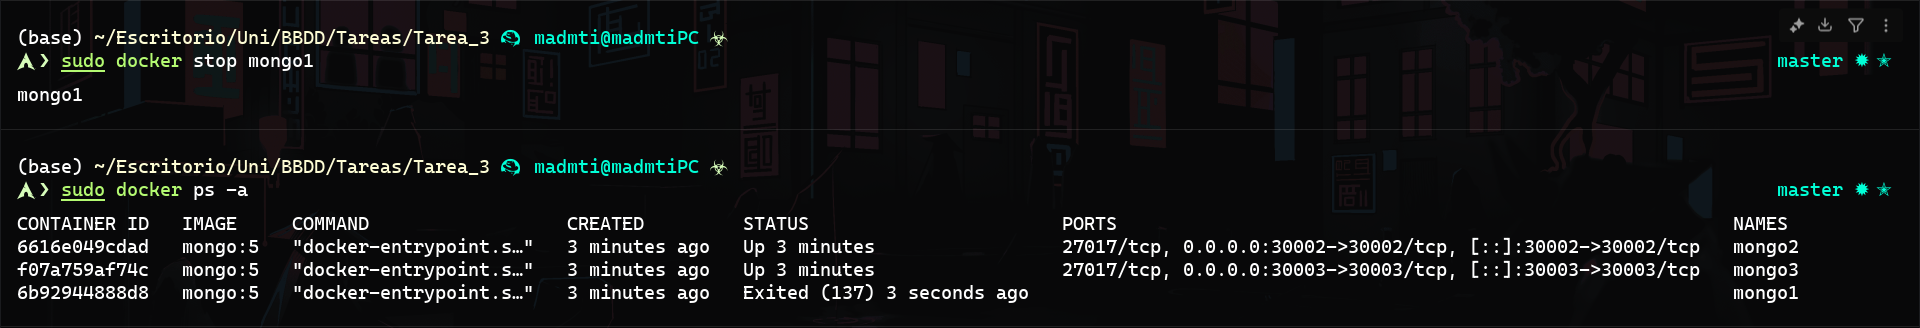

In [ ]:
print_status(client)

# ================== CONSULTA ==================
print("\n=== Consulta de articulos (limit=5) ===\n")
res = collection.find({}, limit=5) #<--- Cliente conectado al Replica Set
print_articles(res)

Estado del Replica Set:
  - mongo1:30001: (not reachable/healthy)
  - mongo2:30002: PRIMARY
  - mongo3:30003: SECONDARY

=== Consulta de articulos (limit=5) ===

Total de artículos encontrados: 5
